# Final Project Module 2

## Advance Data Retrieval and Analysis

* Student Name: Natalia Quintero 
* Student Pace: Full time
* Schedule Project Review: Friday, January 25/2019, 2:30pm PST
* Instructor: Rafael Carrasco
* Blog Post: TBA

## Introduction

<p>The goal of this project is to test the ability to gather information from a "real-world databse" and use statistical analysis and hypothesis testing to generate analytical insights.</p>
<p>The data used for this project is sourced from Microsoft's fictional company Northwind Traders. An sqlite-compatible file has been provided and it's included in the folder along with the notebooks. The project requirements can be found in the index.ipynb file.</p>

### Sections / workflow / procedure

* Connect / analyse/ get familiar with database
* Generate questions
* For each question:
    * Define hypothesis, $Ho$ and $Ha$
    * Select significance level ($\alpha$)
    * Collect data from Northwind database (select/join tables)
    * Choose appropriate test.
    * Calculate statistics. 
    * Interpretation / conclussion
* Summary
* Sources

In [1]:
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns

from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from scipy import stats
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Connect to the Database

engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
# Connection to execute raw SQL statements, one connection for all querys 

con = engine.connect()

2019-01-23 21:42:19,155 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-01-23 21:42:19,157 INFO sqlalchemy.engine.base.Engine ()
2019-01-23 21:42:19,160 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-01-23 21:42:19,161 INFO sqlalchemy.engine.base.Engine ()


-------------

## Data Munging

<p>Inspect tables, get familiar with the database.</p> 
<p>Compare table information with the ERD: looking at the diagram makes it easier to understand relations and create hypothesis, we also get a better understanding of the relationship between entities and their attributes.</p>

<img src="Northwind_ERD.png">

<img src="tableNames.png">

<p>The table names in the db are defined in singular, but this doesn't represent a major issue when retrieving data. There is an extra table that is not shown in the diagram "ProductDetails_V", this table will need to be checked later to see what information it contains in case that it becomes relevant when formulating hypothesis.</p>  
Next I proceed to save each table in a dataframe for better manipulation.

In [4]:
inspector = inspect(engine);

print(inspector.get_table_names())

2019-01-22 08:50:21,786 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-01-22 08:50:21,787 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


### Explore each table (shown in the ERD):

In [9]:
def get_columns_info(col_name):

    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for value in cols_list:
        print("Name: {} \t Type: {}".format(value['name'], value['type']))

In [14]:
get_columns_info('Category')
get_columns_info('Customer')
get_columns_info('CustomerCustomerDemo')
get_columns_info('CustomerDemographic')
get_columns_info('Employee')
get_columns_info('EmployeeTerritory')
get_columns_info('Order')
get_columns_info('OrderDetail')
get_columns_info('Product')
get_columns_info('Region')
get_columns_info('Shipper')
get_columns_info('Supplier')
get_columns_info('Territory')

Table Name: Category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)
Table Name: Customer

Name: Id 	 Type: VARCHAR(8000)
Name: CompanyName 	 Type: VARCHAR(8000)
Name: ContactName 	 Type: VARCHAR(8000)
Name: ContactTitle 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: Phone 	 Type: VARCHAR(8000)
Name: Fax 	 Type: VARCHAR(8000)
Table Name: CustomerCustomerDemo

Name: Id 	 Type: VARCHAR(8000)
Name: CustomerTypeId 	 Type: VARCHAR(8000)
Table Name: CustomerDemographic

Name: Id 	 Type: VARCHAR(8000)
Name: CustomerDesc 	 Type: VARCHAR(8000)
Table Name: Employee

Name: Id 	 Type: INTEGER
Name: LastName 	 Type: VARCHAR(8000)
Name: FirstName 	 Type: VARCHAR(8000)
Name: Title 	 Type: VARCHAR(8000)
Name: TitleOfCourtesy 	 Type: VARCHAR(8000)
Name: BirthDate 	 Type: VARCHAR(8000)
Na

### Table not shown in th ERD

In [15]:
get_columns_info('ProductDetails_V')

2019-01-21 08:52:53,200 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("ProductDetails_V")
2019-01-21 08:52:53,201 INFO sqlalchemy.engine.base.Engine ()
Table Name: ProductDetails_V

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: CategoryDescription 	 Type: VARCHAR(8000)
Name: SupplierName 	 Type: VARCHAR(8000)
Name: SupplierRegion 	 Type: VARCHAR(8000)


In [18]:
inspector.get_pk_constraint('ProductDetails_V')

2019-01-21 09:07:09,157 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ProductDetails_V' AND type = 'table'
2019-01-21 09:07:09,158 INFO sqlalchemy.engine.base.Engine ()


{'constrained_columns': [], 'name': None}

In [19]:
inspector.get_foreign_keys('ProductDetails_V')

2019-01-21 09:07:16,568 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("ProductDetails_V")
2019-01-21 09:07:16,569 INFO sqlalchemy.engine.base.Engine ()
2019-01-21 09:07:16,573 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ProductDetails_V' AND type = 'table'
2019-01-21 09:07:16,574 INFO sqlalchemy.engine.base.Engine ()


[]

#### Conclussion
This table has no foreign key or primary key. It seems to be a join-table between Product and Category. Most probably was a table created and never deleted from previous manipulation of the database. I conclude this table is not part of the initial database model.

---------------

## Hypotheis Statements 

1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. How sales compare with revenue across the different regions.
3. How employees compare among themselves.
4. Do discounts affect reorders?
    

### Analysis of hypothesis 1
Do discounts have a statistically significant effect on the number of products customers order? 

#### State null and alternative hypothesis
* $H_o$: discounts do not have an effect on the number of products ordered. $\mu_1 =\mu_2$
* $Ha$: discounts have an effect in the number of products ordered. $\mu_1 !=\mu_2$

#### Significance level 

$\alpha$ = 0.05

Since the question is asking for a "significant effect" this will be a two-tail test.

#### Collect data

Table needed: Order (attributes: orderid, quantity, discount) 

In [6]:
# Read OrderDertail table into a dataframe

dfOrderDetail = pd.read_sql_query('''select * from [OrderDetail]''', engine);

dfOrderDetail.head()

2019-01-23 08:13:25,229 INFO sqlalchemy.engine.base.Engine select * from [OrderDetail]
2019-01-23 08:13:25,230 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [25]:
#overview of the table

dfOrderDetail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [6]:
# check for null values

dfOrderDetail['Discount'].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [7]:
dfOrderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

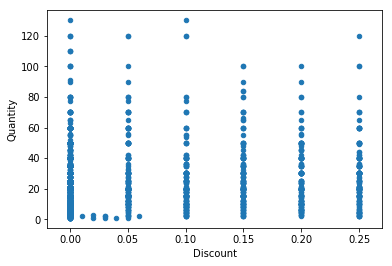

In [9]:
# frequency of each value

dfOrderDetail.plot.scatter('Discount', 'Quantity')
plt.show()

At a first look it doesn't seem that dicounts affect the quantity of products ordered. Let's look at the mean for discounted and non discounted items.

In [8]:
#divide table and make a dataframe for discounted and non-discounted products  

df_NoDiscount = pd.read_sql_query('''select Quantity, Discount from [OrderDetail] where Discount == 0.00''', engine)
df_Discount = pd.read_sql_query('''select Quantity, Discount from [OrderDetail] where Discount != 0.00''', engine)

2019-01-23 08:13:54,163 INFO sqlalchemy.engine.base.Engine select Quantity, Discount from [OrderDetail] where Discount == 0.00
2019-01-23 08:13:54,165 INFO sqlalchemy.engine.base.Engine ()
2019-01-23 08:13:54,173 INFO sqlalchemy.engine.base.Engine select Quantity, Discount from [OrderDetail] where Discount != 0.00
2019-01-23 08:13:54,174 INFO sqlalchemy.engine.base.Engine ()


In [34]:
print('Descriptive statistics for non-discounted items')
df_NoDiscount.describe()

#mean 21.72

Descriptive statistics for non-discounted items


,Quantity,Discount
count,1317.000000,1317.0
mean,21.715262,0.0
std,17.507493,0.0
min,1.000000,0.0
25%,10.000000,0.0
50%,18.000000,0.0
75%,30.000000,0.0
max,130.000000,0.0


In [33]:
print('Descripive statistics for Discounted items')
df_Discount.describe()

#mean 27.11

Descripive statistics for Discounted items


,Quantity,Discount
count,838.000000,838.000000
mean,27.109785,0.144439
std,20.771439,0.071808
min,1.000000,0.010000
25%,12.000000,0.100000
50%,20.000000,0.150000
75%,36.000000,0.200000
max,130.000000,0.250000


####  Test: Independent sample t Test
Is used to compares two averages (means) and see if they are different from each other and how significant the differences are.

#### Assumptions

    * Dependent variable: number of orders (quantity)
    * Independent variable: discount

* Independence. Two groups that represent the independent variable: with discount and without discount.
* Normality. The dependent variable should be approximately normally distributed.
* Variance

#### Check for normality

/Users/natalia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


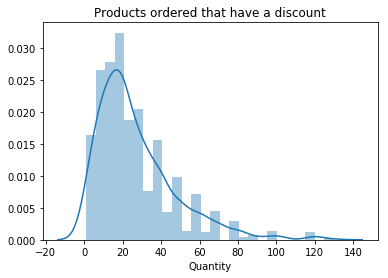

In [32]:
plt.figure()
sns.distplot(df_Discount['Quantity'], label='Discount group');
plt.title('Products ordered that have a discount');

/Users/natalia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


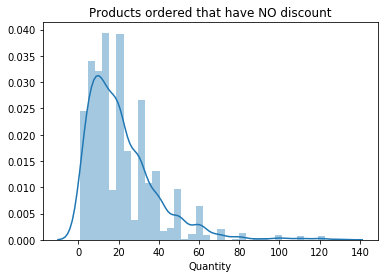

In [34]:
plt.figure()
sns.distplot(df_NoDiscount['Quantity'], label='No Discount group');
plt.title('Products ordered that have NO discount');

In both groups the variable quantity is aproximately normally distributed.

#### Check for variance


In [20]:
# variance no discount

np.var(df_NoDiscount)

Quantity    306.279592
Discount      0.000000
dtype: float64

In [21]:
#variance discount

np.var(df_Discount)

Quantity    430.937828
Discount      0.005150
dtype: float64

#### P-value 

In [35]:
# two side test

scipy.stats.ttest_ind(df_NoDiscount['Quantity'], df_Discount['Quantity'], equal_var=False)

Ttest_indResult(statistic=-6.239069142123973, pvalue=5.65641429030433e-10)

#### Interpretation

The null hypothesis is rejected. Discounts do not seem to have a stistically siginificant effect on the number of products ordered by clients.

-----------

### Analysis of hypothesis 2

How sales and revenue compare across the regions. 

#### State null and alternative hypothesis

* $H_o$: higher number of sales do not mean more revenue . $\mu_1 =\mu_2$
* $Ha$: higher number of sales means more revenue  $\mu_1 > \mu_2$

#### Significance level 

$\alpha$ = 0.05

#### Collect data

In [6]:
# From the table Order we take the number of orders to each region

df_order = pd.read_sql_query('''select * from [Order]''', engine);
df_order['ShipRegion'].value_counts()

# Total sales in Europe: 402, total sales in the Americas: 325

2019-01-24 08:50:52,868 INFO sqlalchemy.engine.base.Engine select * from [Order]
2019-01-24 08:50:52,870 INFO sqlalchemy.engine.base.Engine ()


Western Europe     276
North America      152
South America      145
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     28
Eastern Europe       7
Name: ShipRegion, dtype: int64

In [13]:
df1_order = pd.read_sql_query('''select ShipRegion, sum(Freight) as TotalSum, count(ShipRegion) as Sales from [Order] 
group by ShipRegion''', engine)
df1_order

2019-01-24 10:00:21,394 INFO sqlalchemy.engine.base.Engine select ShipRegion, sum(Freight) as TotalSum, count(ShipRegion) as Sales from [Order] 
group by ShipRegion
2019-01-24 10:00:21,396 INFO sqlalchemy.engine.base.Engine ()


,ShipRegion,TotalSum,Sales
0,British Isles,5709.51,75
1,Central America,1122.78,28
2,Eastern Europe,175.74,7
3,North America,15969.38,152
4,Northern Europe,4633.79,55
5,Scandinavia,1186.39,28
6,South America,8213.95,145
7,Southern Europe,2369.86,64
8,Western Europe,25561.29,276


####  Test: ANOVA test

It's used when you want to test different groups to see if there is a difference between them.

#### Generate ANOVA table (AOV)

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [39]:
formula = 'TotalSum ~ Sales'
lm = ols(formula, df1_order).fit()
lm.summary()

/Users/natalia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalSum   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     113.7
Date:                Thu, 24 Jan 2019   Prob (F-statistic):           1.40e-05
Time:                        14:40:31   Log-Likelihood:                -80.791
No. Observations:                   9   AIC:                             165.6
Df Residuals:                       7   BIC:                             166.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1645.2435   1102.177     -1.493      0.179   -4251.479     960.991
Sales         96.0842      9.010     10.664      0.000      74.778     117.390
==============================================================================
Omnibus:                        2.803   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.246   Jarque-Bera (JB):                0.842
Skew:                          -0.746   Prob(JB):                        0.656
Kurtosis:                       3.142   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq   df           F    PR(>F)
Sales     5.366067e+08  1.0  113.716357  0.000014
Residual  3.303172e+07  7.0         NaN       NaN


The probability that sales are influencial is very low, much less that our estimate of 0.05; this indicates a rejection of the null hypothesis.

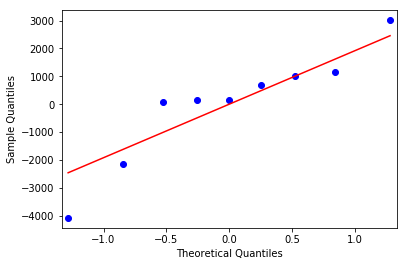

In [37]:
res = lm.resid 
fig = sm.qqplot(res, line='s')
plt.show()

#### Interpretation

The null hypothesis is rejected, this confirms revenue is increased by the number of products ordered and not by the price.

---------

### Analysis of hypothesis 3

How employee sales compare among themselves

#### State null and alternative hypothesis

* $H_o$: orders taken by employees on average are the same quantity $\mu_1 =\mu_2$
* $Ha$: there is an employee that takes more orders than the average $\mu_1 >\mu_2$

#### Significance level 

$\alpha$ = 0.05


#### Collect data

In [41]:
# Read the total value sold by each employee

df31_order = pd.read_sql_query('''select EmployeeId, sum(Freight) as OrderTotal from [Order] group by 
EmployeeId order by OrderTotal ASC''', engine)
df31_order

2019-01-24 18:01:02,796 INFO sqlalchemy.engine.base.Engine select EmployeeId, sum(Freight) as OrderTotal from [Order] group by 
EmployeeId order by OrderTotal ASC
2019-01-24 18:01:02,800 INFO sqlalchemy.engine.base.Engine ()


,EmployeeId,OrderTotal
0,9,3326.26
1,6,3780.47
2,5,3918.71
3,7,6665.44
4,8,7487.88
5,2,8696.41
6,1,8836.64
7,3,10884.74
8,4,11346.14


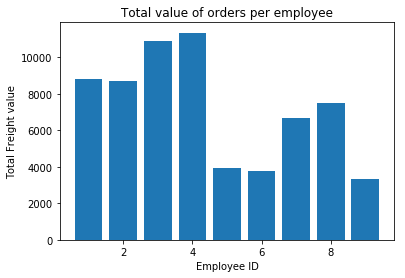

In [44]:
x = df31_order['EmployeeId']
y =df31_order['OrderTotal']
plt.bar(x,y)

plt.title('Total value of orders per employee')
plt.xlabel('Employee ID')
plt.ylabel('Total Freight value')

plt.show()

In [42]:
df31_order.describe()

,EmployeeId,OrderTotal
count,9.000000,9.000000
mean,5.000000,7215.854444
std,2.738613,3031.457926
min,1.000000,3326.260000
25%,3.000000,3918.710000
50%,5.000000,7487.880000
75%,7.000000,8836.640000
max,9.000000,11346.140000


####  Test: ANOVA

Assumptions to be satisfied in order for the associated p-value to be valid.

    The samples are independent.
    Each sample is from a normally distributed population.
    The population standard deviations of the groups are all equal (homoscedasticity)

The assumption of homoscedasticity does not hold in this case, so we use the Kruskal-Wallis H-test which tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA.

In [54]:
stats.kruskal(x,y)

KruskalResult(statistic=12.78947368421052, pvalue=0.0003485751742130545)

#### Interpretation

The pvalue is much lower than the statistic value, hence the null hypothesis is rejected. 

---------

### Analysis of hypothesis 4

Do discounts affect reorders?

#### State null and alternative hypothesis

* $H_o$: discounts have an effect on reorders $\mu_1 =\mu_2$
* $Ha$: discounts do not have an effect in reorders $\mu_1 !=\mu_2$

#### Significance level 

$\alpha$ = 0.05

Since the question is asking for a "significant effect" this will be a two-tail t-test.


#### Collect data

In [55]:
# dataframe products with no discount 

dfp_reord = pd.read_sql_query('''select p.Id, p.ReorderLevel, od.Discount from [Product] p join [OrderDetail] od
on p.Id=od.ProductId where Discount == 0.00''', engine)
dfp_reord

2019-01-24 19:37:38,872 INFO sqlalchemy.engine.base.Engine select p.Id, p.ReorderLevel, od.Discount from [Product] p join [OrderDetail] od
on p.Id=od.ProductId where Discount == 0.00
2019-01-24 19:37:38,874 INFO sqlalchemy.engine.base.Engine ()


,Id,ReorderLevel,Discount
0,11,30,0.0
1,42,0,0.0
2,72,0,0.0
3,14,0,0.0
4,51,10,0.0
5,41,10,0.0
6,65,0,0.0
7,60,0,0.0
8,31,20,0.0
9,39,5,0.0


In [57]:
dfp_reord.describe()

,Id,ReorderLevel,Discount
count,1317.000000,1317.000000,1317.0
mean,41.396355,11.856492,0.0
std,22.217410,10.839948,0.0
min,1.000000,0.000000,0.0
25%,23.000000,0.000000,0.0
50%,41.000000,10.000000,0.0
75%,60.000000,20.000000,0.0
max,77.000000,30.000000,0.0


In [56]:
#dataframe products with discount

dfp_reornod = pd.read_sql_query('''select p.Id, p.ReorderLevel, od.Discount from [Product] p join [OrderDetail] od
on p.Id=od.ProductId where Discount > 0.00''', engine)
dfp_reornod

2019-01-24 19:38:06,223 INFO sqlalchemy.engine.base.Engine select p.Id, p.ReorderLevel, od.Discount from [Product] p join [OrderDetail] od
on p.Id=od.ProductId where Discount > 0.00
2019-01-24 19:38:06,225 INFO sqlalchemy.engine.base.Engine ()


,Id,ReorderLevel,Discount
0,51,10,0.15
1,65,0,0.15
2,22,25,0.05
3,57,20,0.05
4,20,0,0.05
5,33,20,0.05
6,24,0,0.15
7,55,20,0.15
8,2,25,0.20
9,5,0,0.20


In [58]:
dfp_reornod.describe()

,Id,ReorderLevel,Discount
count,838.000000,838.000000,838.000000
mean,39.844869,11.968974,0.144439
std,22.046812,10.720808,0.071808
min,1.000000,0.000000,0.010000
25%,21.000000,0.000000,0.100000
50%,40.000000,10.000000,0.150000
75%,59.000000,20.000000,0.200000
max,77.000000,30.000000,0.250000


####  Assumptions

##### Normality

/Users/natalia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


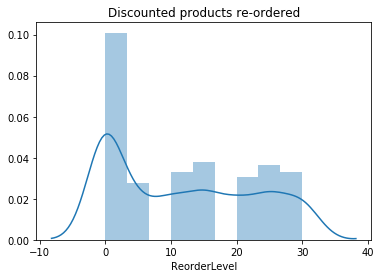

In [60]:
plt.figure()
sns.distplot(dfp_reord['ReorderLevel'], label='Reorder');
plt.title('Discounted products re-ordered');

/Users/natalia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


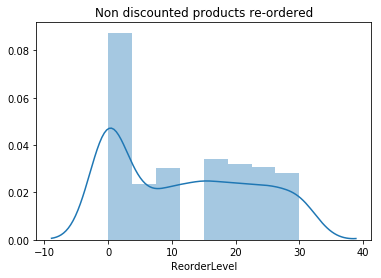

In [61]:
plt.figure()
sns.distplot(dfp_reornod['ReorderLevel'], label='Reorder');
plt.title('Non discounted products re-ordered');

##### Variance

In [62]:
np.var(dfp_reord)

Id              493.238498
ReorderLevel    117.415244
Discount          0.000000
dtype: float64

In [63]:
np.var(dfp_reornod)

Id              485.481901
ReorderLevel    114.798560
Discount          0.005150
dtype: float64

#### Test: two tail t-test

In [64]:
scipy.stats.ttest_ind(dfp_reord['ReorderLevel'], dfp_reornod['ReorderLevel'], equal_var=False)

Ttest_indResult(statistic=-0.23641044437129016, pvalue=0.8131411415021936)

#### Interpretation

The p-value in this case is greater than the significance level, so the null hypothesis is not rejected. 

## Summary

1. Do discounts have a statistically significant effect on the number of products customers order? 
    * $H_o$: discounts do not have an effect on the number of products ordered. $\mu_1 =\mu_2$
    * $Ha$: discounts have an effect in the number of products ordered. $\mu_1 !=\mu_2$
<p>The null hypothesis is rejected. Discounts do not seem to have a stistically siginificant effect on the number of products ordered by clients.</p><br>

2. How sales and revenue compare across the regions. Do more orders means more revenue?
    * $H_o$: higher number of sales do not mean more revenue . $\mu_1 =\mu_2$
    * $Ha$: higher number of sales means more revenue  $\mu_1 > \mu_2$
<p>The null hypothesis is rejected, this confirms revenue is increased by the number of products ordered and not by the price of the products. Had the null hypothesis not been rejected it could have meant the possibility of having a region order the most expensive product(s) only, hence revenue will be based on price of a very few number of products.</p><br>

3. How employee sales compare among themselves
    * $H_o$: orders taken by employees on average are the same quantity $\mu_1 =\mu_2$
    * $Ha$: there is an employee that takes more orders than the average $\mu_1 >\mu_2$
<p>The statement that orders taken by employees on average are the same quantity is rejected. Some employees take more orders than the average, this leads to further analysis on the date each employee started at the company and how this reflects in the orders taken by each of them.</p><br> 

4. Do discounts affect reorders?
    * $H_o$: discounts have an effect on reorders $\mu_1 =\mu_2$
    * $Ha$: discounts do not have an effect in reorders $\mu_1 !=\mu_2$
The alternate hypothesis that discounts do not have an effect in reorders is weak, so the null hypothesis can not be rejected.

## Future Analyses

Some other hypothesis to test in the future:

* Group total sales in Europe Region and sales in the Americas, compare number of sales and revenue and check if there is a significant difference. Probably open an ofice in Europe. 
* what category sells most and where (region, country) ; maybe decrease or increase prices, change level of discount?
* Customer - Employee relation. Is there a preference for an employee?
* How national sales compare with international sales


# Sources

* [SQLAlchemy Documentation][s1] 
* [Introduction to hypothesis testing][s2]

[s1]: https://docs.sqlalchemy.org/en/latest/core/reflection.html?highlight=inspector#sqlalchemy.engine.reflection.Inspector.get_table_names.params.order_by
[s2]:https://newonlinecourses.science.psu.edu/stat500/node/39/
